# roughnecks - stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 8 # roughnecks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNLL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(7978, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7978 entries, 0 to 7977
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            7978 non-null   int64  
 1   dimCustomerMasterId     7978 non-null   int64  
 2   customerNumber          7978 non-null   object 
 3   year                    7978 non-null   int64  
 4   productGrouping         7978 non-null   object 
 5   totalSpent              7978 non-null   float64
 6   recentDate              7978 non-null   object 
 7   attendancePercent       7978 non-null   float64
 8   renewedBeforeDays       7974 non-null   float64
 9   isBuyer                 7978 non-null   object 
 10  source_tenure           7978 non-null   int64  
 11  tenure                  7974 non-null   float64
 12  distToVenue             7978 non-null   float64
 13  totalGames              7978 non-null   int64  
 14  recency                 7978 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5700, 13)
Unseen Data For Predictions: (1006, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8055,0.8371,0.9011,0.8144,0.8555,0.5605,0.5677,0.4250
lr,Logistic Regression,0.6474,0.6253,0.9580,0.6528,0.7764,0.0676,0.1097,0.5220


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7814,0.8279,0.8742,0.8018,0.8364,0.5091,0.5134
1,0.8124,0.8311,0.9129,0.8156,0.8615,0.5736,0.5824
2,0.8062,0.8549,0.8806,0.8273,0.8531,0.5691,0.5715
3,0.8206,0.8507,0.9226,0.8195,0.8680,0.5913,0.6015
4,0.8037,0.8264,0.9226,0.8011,0.8576,0.5469,0.5612
5,0.8099,0.8552,0.8932,0.8239,0.8571,0.5746,0.5788
6,0.8099,0.8345,0.8964,0.8220,0.8576,0.5735,0.5784
7,0.7851,0.8025,0.8867,0.7988,0.8405,0.5141,0.5207
8,0.8058,0.8532,0.9061,0.8116,0.8563,0.5597,0.5678
9,0.8202,0.8349,0.9159,0.8227,0.8668,0.5930,0.6011


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(1272, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
6706,8,328762491,2578114,2021,Full Season,6024.44,2022-02-18,0.816667,98.0,TRUE,...,0,0,144.0,1,10,0,0,1,0.1822,0.8178
6707,8,328784787,7594832,2021,Full Season,1516.75,2022-02-18,1.000000,98.0,TRUE,...,0,0,0.0,1,10,0,0,1,0.1378,0.8622
6708,8,328791692,11003018,2021,Full Season,788.70,2022-02-18,1.000000,46.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.7967,0.2033
6709,8,328795026,128216,2021,Full Season,693.69,2022-02-18,1.000000,98.0,TRUE,...,0,0,0.0,1,10,0,0,1,0.3439,0.6561
6710,8,328798634,2104211,2021,Full Season,1905.16,2022-02-11,1.000000,98.0,TRUE,...,0,0,0.0,1,10,0,0,0,0.6047,0.3953


In [11]:
new_predictions["Label"].value_counts()

0    1108
1     164
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    892
(0.2, 0.4]       165
(0.4, 0.6]        98
(0.6, 0.8]        81
(0.8, 1.0]        36
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

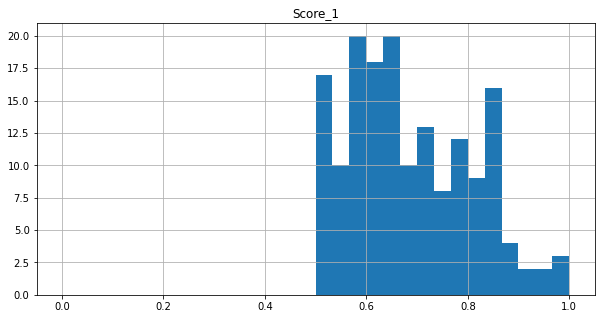

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

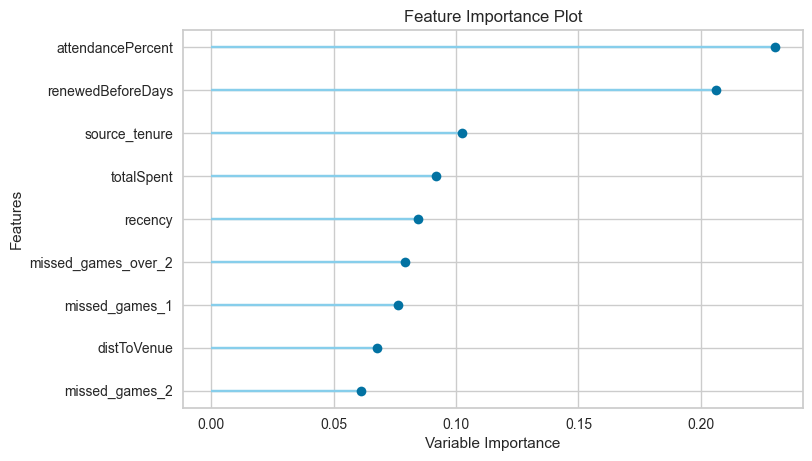

In [14]:
plot_model(best_model, plot='feature')

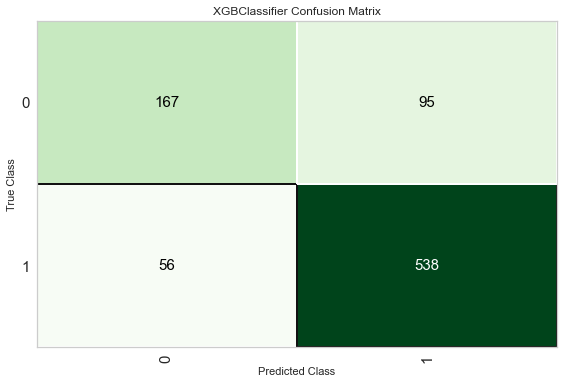

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?